In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
pd.set_option('display.max_row',111)
pd.set_option('display.max_column',111) # pour afficher toute les colonnes

In [3]:
data = pd.read_excel("dataset.xlsx")
data

Patient ID  Patient age quantile SARS-Cov-2 exam result  \
0     44477f75e8169d2                    13               negative   
1     126e9dd13932f68                    17               negative   
2     a46b4402a0e5696                     8               negative   
3     f7d619a94f97c45                     5               negative   
4     d9e41465789c2b5                    15               negative   
...               ...                   ...                    ...   
5639  ae66feb9e4dc3a0                     3               positive   
5640  517c2834024f3ea                    17               negative   
5641  5c57d6037fe266d                     4               negative   
5642  c20c44766f28291                    10               negative   
5643  2697fdccbfeb7f7                    19               positive   

      Patient addmited to regular ward (1=yes, 0=no)  \
0                                                  0   
1                                                  0   
2                                                  0   
3                                                  0   
4                                                  0   
...                                              ...   
5639                                               0   
5640                                               0   
5641                                               0   
5642                                               0   
5643                                               0   

      Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                     0       
1                                                     0       
2                                                     0       
3                                                     0       
4                                                     0       
...                                                 ...       
5639                                                  0       
5640                                                  0       
5641                                                  0       
5642                                                  0       
5643                                                  0       

      Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                     0             NaN   
1                                                     0        0.236515   
2                                                     0             NaN   
3                                                     0             NaN   
4                                                     0             NaN   
...                                                 ...             ...   
5639                                                  0             NaN   
5640                                                  0             NaN   
5641                                                  0             NaN   
5642                                                  0             NaN   
5643                                                  0        0.694287   

      Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  \
0            NaN        NaN                    NaN              NaN   
1      -0.022340  -0.517413               0.010677         0.102004   
2            NaN        NaN                    NaN              NaN   
3            NaN        NaN                    NaN              NaN   
4            NaN        NaN                    NaN              NaN   
...          ...        ...                    ...              ...   
5639         NaN        NaN                    NaN              NaN   
5640         NaN        NaN                    NaN              NaN   
5641         NaN        NaN                    NaN              NaN   
5642         NaN        NaN                    NaN              NaN   
5643    0.541564  -0.906829              -0.325903        

# DEMARCHE DE L'ESPRIT POUR ANALYSER UN JEU DE DONNEES

# 1. Définir un objectif mesurable:
- **Objectif:** Predire si une personne est infectee en fonction des donnees cliniques disponibles
- **Métrique:** Acuuracy -> 90%; Précision; Recall (sensibilité) -> 70%; Score F1 (elements qu'on trouve dans une matrice de confusion)


# 2. Analyse exploratoire des donnees (Exploratory Data Analysis EDA)

### 2.1 **Objectif:** Comprendre au maximum les donnees dont on dispose pour definir une strategie de modelisation.

### 2.2 **Analyse de la forme**
- **Identification de la target:**: SARS-Cov-2 exam result
- **Nombre de lignes et de colonnes:** (5644,111)
- **Type de variables:** 70 variables qualitatives et 41 quantitatives
- **Identification des valeurs manquantes:** 
    - Beaucoup de NaN (moitie des variables > 90% de NaN) 
    - 2 groupes de donnees ( 76% -> Test viral, 89% -> taux sanguins)

### 2.3 **Analyse du fond**
- **Visualisation de la target:** (Histogramme / Boxplot)
    - 10% de positifs (558/5000)
    - 90% de negatifs
- **Comprehension des differentes variables:** (si possible faire des recherches sur internet)
    - variables continues standardisees, skewed (asymetriques), test sanguin
    - variable age quantile: difficile d'interpreter ce graphique, clairement ces donnees ont ete traitees, on pourrait penser 0-5, mais cela pourrait aussi etre une transformation mathematique. On peut pas savoir car la personne qui a mit ce dataset ne le precise nul part. Mais ce n'est pas tres important
    - variable qualitative: binaire(0,1), viral, Rhinovirus qui semble tres elevee
- **Visualisation des relations features-target** (Histogramme / Boxplot)
    - target / blood_columns: les taux de Monocytes, Platelets, Leukocytes semblent lies au covid-19 (hypothese a tester)
    - target / age: Les individus de faible age sont tres peu contamines ? -> attention on ne connait pas l'age, et on ne sait pas de quand date le dataset (s'il s'agit des enfants on sait que les enfants sont touches autant que les adultes). En revanche cette variable pourra etre interessante pour la comparer avec les resultats de tests sanguins
    - target / viral_columns: les doubles maladies sont tres rares. Rhinovirus/Enterovirus positif - covid-19 negatif? -> hypothese a tester? mais il est possible que la region est subie une epidemie de ce virus. De plus on peut tres bien avoir 2 virus en meme temps. Tout ca n'a aucun lien avec le covid-19

### 2.4 **Analyse plus detaillee**
- **Relations Variables / variables:**
    - blood_data / blood_data: certaines variables sont tres correlees: +0.9 (a surveiller plus tard)
    - blood_data / age: on a observe une tres faible correlation entre age et taux sanguins
    - viral / viral: influenza rapid test donne de mauvais resultats, il faudra peut-etre la laisser tomber
    - relation maladie / blood data: On a pu observer que les taux sanguins entre malades et covid-19 sont different
    - relation hospitalisation / est malade:
    - relation hospitalisation / blood: interessant dans le cas ou veut predire dans quelle service un patient devrait aller
- **Identification des outliers:**
- **analyse des NaN:** viral: 1350(92/8), blood: 600 (87/13), both: 90

### 2.5 Hypotheses nulle (H0)
- Les individus atteints du covid-19 ont des taux de Leukocytes, Monocytes, Platelets significativement differents
    - H0 = Les taux moyens sont EGAUX chez les individus positifs et negatifs (On va la verifiee avec les test statistique de Student qui permet de verifier si la moyenne entre deux distributions est significativement different) chez les individus positifs et negatifs
- Les individus atteints d'une quelconque maladie ont des taux significativement differents

In [4]:
df = data.copy()

In [5]:
# Analyse de la forme des donnnees
print(df.shape)
print(df.dtypes.value_counts()) # 70 variables qualitatives et 41 quantitatives

(5644, 111)
float64    70
object     37
int64       4
dtype: int64


<AxesSubplot:>

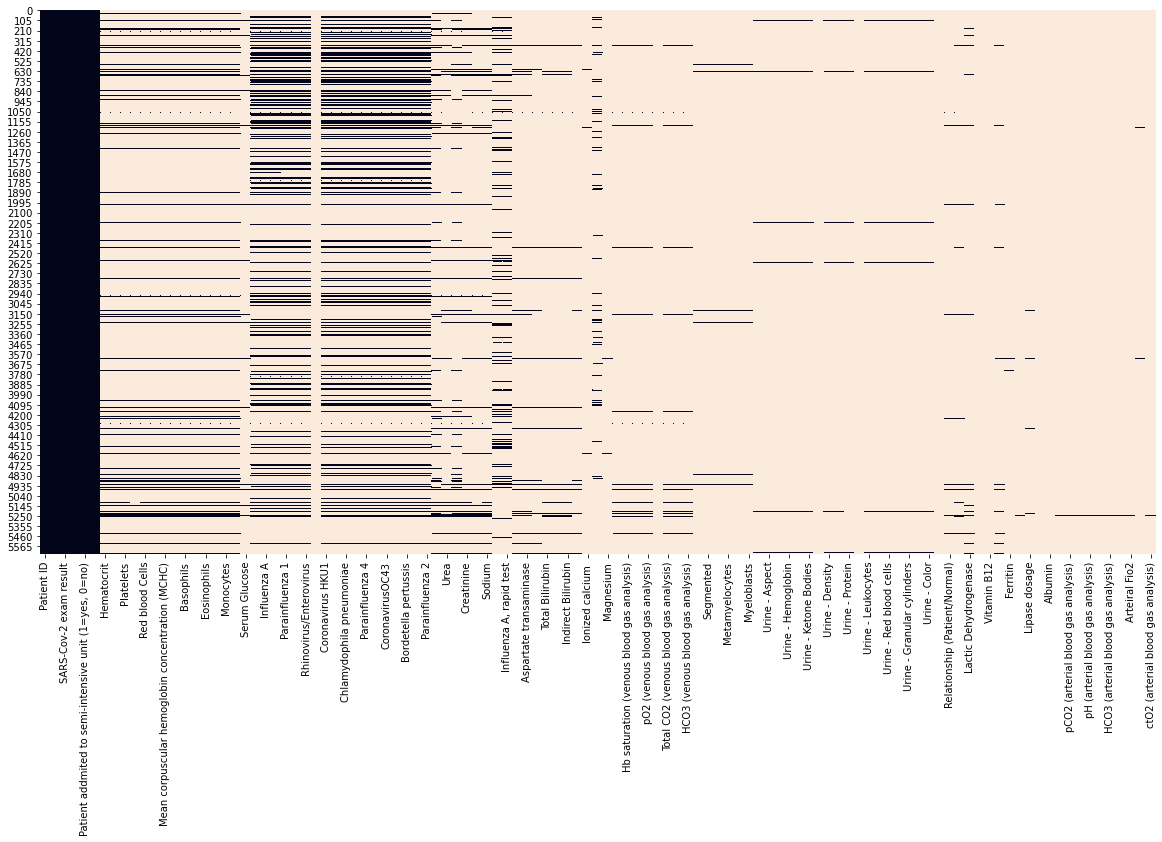

In [6]:
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(),cbar=False)

In [7]:
(df.isna().sum()/df.shape[0]).sort_values(ascending=True) # Nombre ou pourcentage de valeurs manquantes dans chaque colonne du jeu de donnees.

Patient ID                                               0.000000
Patient age quantile                                     0.000000
SARS-Cov-2 exam result                                   0.000000
Patient addmited to regular ward (1=yes, 0=no)           0.000000
Patient addmited to semi-intensive unit (1=yes, 0=no)    0.000000
Patient addmited to intensive care unit (1=yes, 0=no)    0.000000
Influenza B                                              0.760099
Respiratory Syncytial Virus                              0.760099
Influenza A                                              0.760099
Rhinovirus/Enterovirus                                   0.760454
Inf A H1N1 2009                                          0.760454
CoronavirusOC43                                          0.760454
Coronavirus229E                                          0.760454
Parainfluenza 4                                          0.760454
Adenovirus                                               0.760454
Chlamydoph

In [8]:
# Analyse de fond des donnees

# Nettoyage des variables ayant un pourcentage de valeurs manquantes elevees
df = df[df.columns[df.isna().sum()/df.shape[0] < 0.9]]
df = df.drop("Patient ID", axis=1)

<AxesSubplot:>

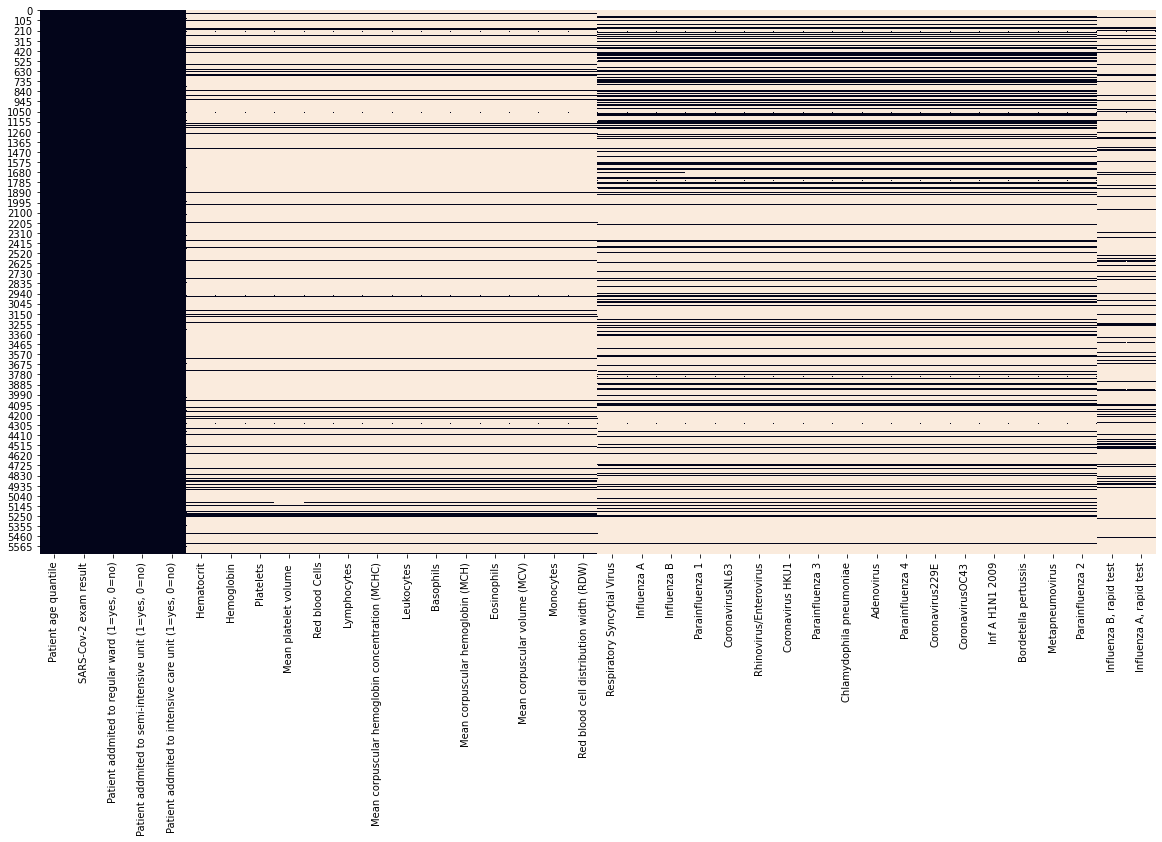

In [9]:
# on reaffiche le nouveau dataframe
plt.figure(figsize=(20,10))
sns.heatmap(df.isna(), cbar=False)

In [10]:
# Visualisation de la target

df['SARS-Cov-2 exam result'].value_counts(normalize=True) # On peut affirmer que les classes ne sont pas equilibrees

negative    0.901134
positive    0.098866
Name: SARS-Cov-2 exam result, dtype: float64

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

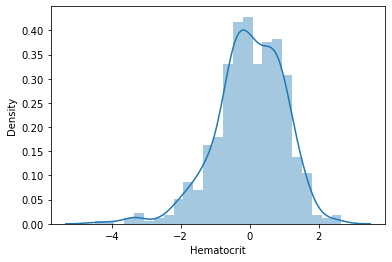

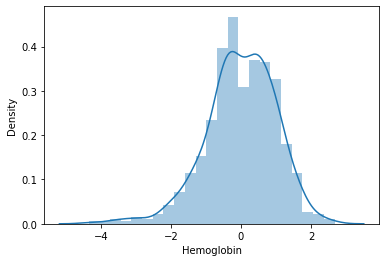

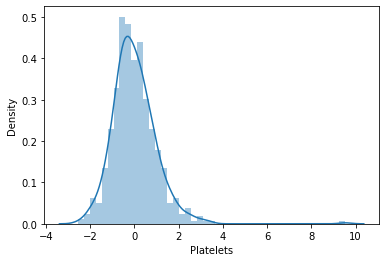

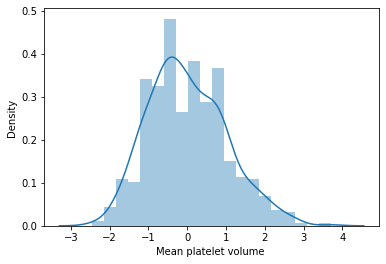

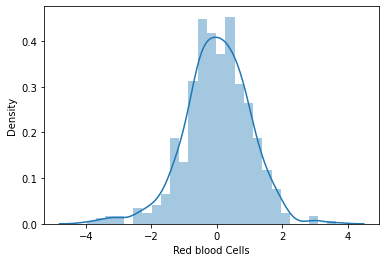

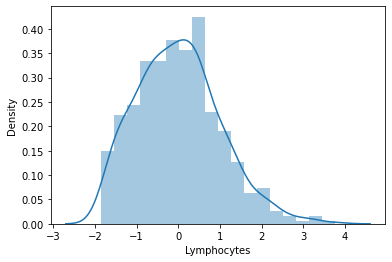

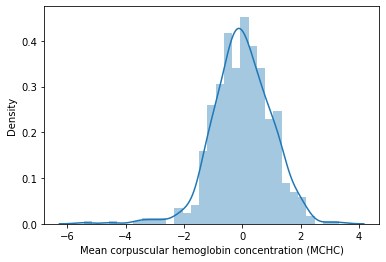

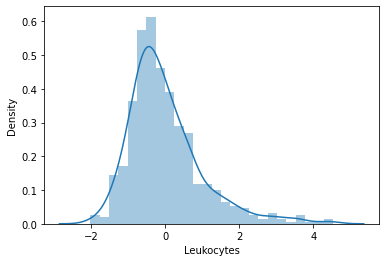

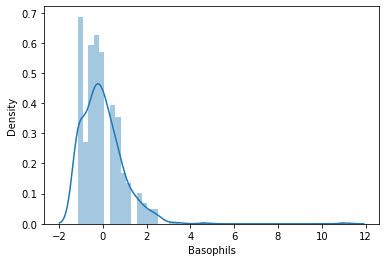

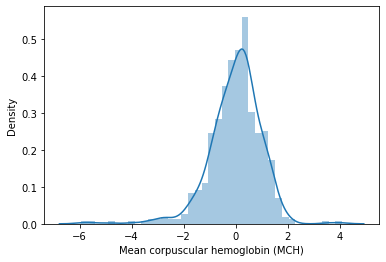

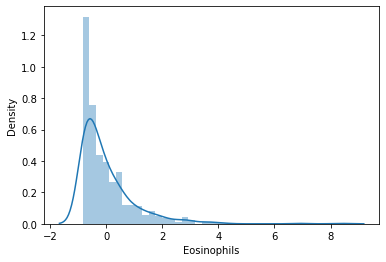

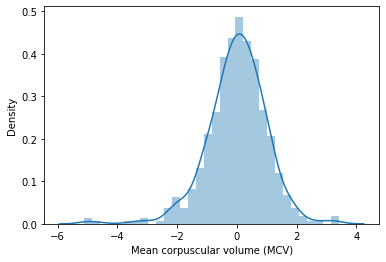

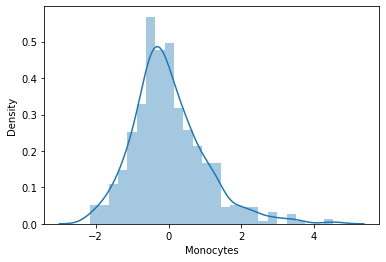

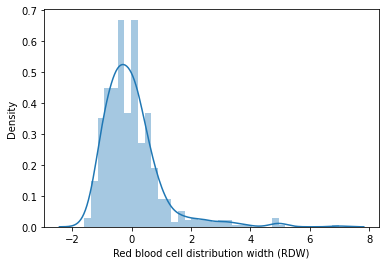

In [11]:
# histogrammes des variables continues
for col in df.select_dtypes('float'):
    plt.figure()
    sns.distplot(df[col])

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Patient age quantile', ylabel='Density'>

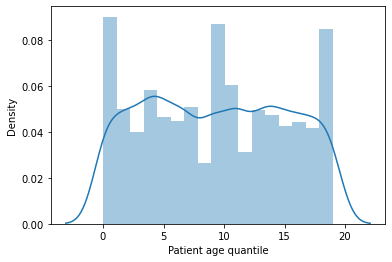

In [12]:
sns.distplot(df['Patient age quantile'])

In [13]:
# variables qualitatives
# on cherche a connaitre le type ou classe de variable qu'il ya dans chaque colonne
for col in df.select_dtypes('object'):
    print(f'{col :-<50} {df[col].unique()}')

SARS-Cov-2 exam result---------------------------- ['negative' 'positive']
Respiratory Syncytial Virus----------------------- [nan 'not_detected' 'detected']
Influenza A--------------------------------------- [nan 'not_detected' 'detected']
Influenza B--------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 1----------------------------------- [nan 'not_detected' 'detected']
CoronavirusNL63----------------------------------- [nan 'not_detected' 'detected']
Rhinovirus/Enterovirus---------------------------- [nan 'detected' 'not_detected']
Coronavirus HKU1---------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 3----------------------------------- [nan 'not_detected' 'detected']
Chlamydophila pneumoniae-------------------------- [nan 'not_detected' 'detected']
Adenovirus---------------------------------------- [nan 'not_detected' 'detected']
Parainfluenza 4----------------------------------- [nan 'not_detected' 'detected']
Coronavirus2

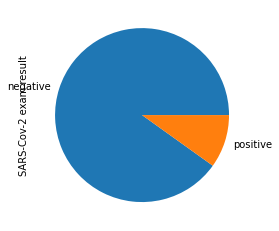

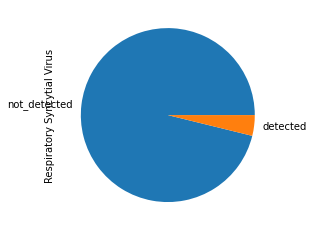

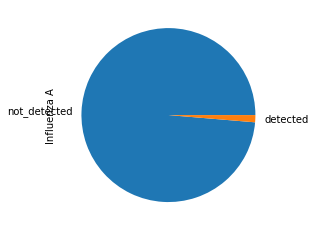

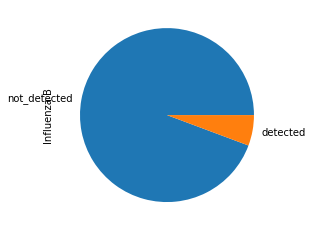

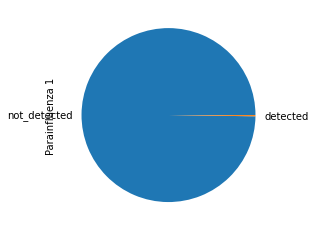

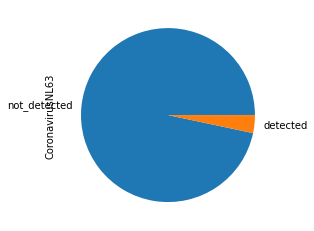

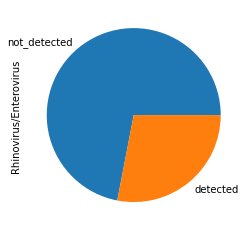

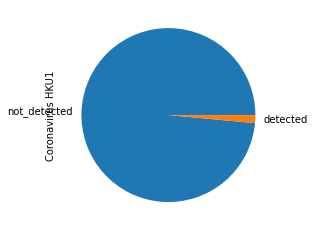

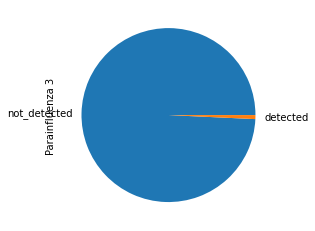

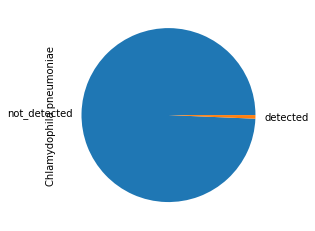

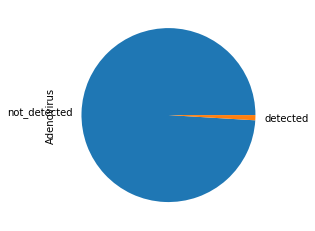

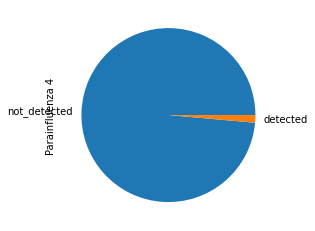

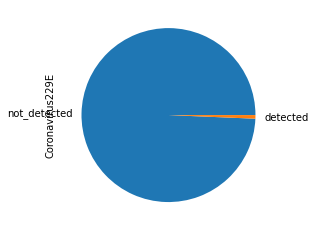

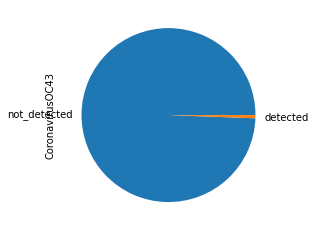

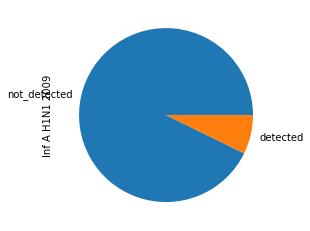

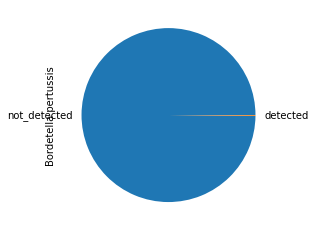

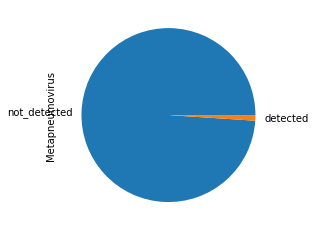

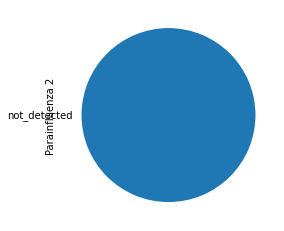

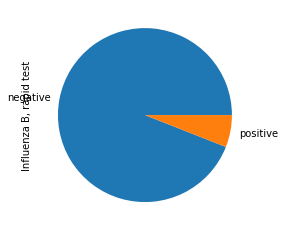

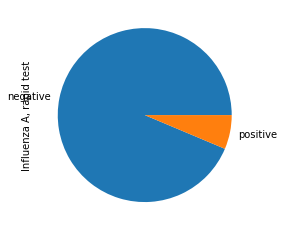

In [14]:
# on cherche a connaitre le nombre correspondant a chaque type de variable qu'il ya dans chaque colonne
for col in df.select_dtypes('object'):
    plt.figure()
    df[col].value_counts().plot.pie()

In [15]:
# Visualisation de la relation Target/Variables
# Creation de sous-ensembles positifs et negatifs (en faisant le boolean indexing)
positive_df = df[df['SARS-Cov-2 exam result'] == 'positive']
negative_df = df[df['SARS-Cov-2 exam result'] == 'negative']

# Creation des ensembles Blood et viral
missing_rate = df.isna().sum()/df.shape[0]
blood_columns = df.columns[(missing_rate < 0.9) & (missing_rate > 0.88)]
viral_columns = df.columns[(missing_rate < 0.88) & (missing_rate > 0.75)]
print(blood_columns)
print("")
print(viral_columns)

Index(['Hematocrit', 'Hemoglobin', 'Platelets', 'Mean platelet volume ',
       'Red blood Cells', 'Lymphocytes',
       'Mean corpuscular hemoglobin concentration (MCHC)', 'Leukocytes',
       'Basophils', 'Mean corpuscular hemoglobin (MCH)', 'Eosinophils',
       'Mean corpuscular volume (MCV)', 'Monocytes',
       'Red blood cell distribution width (RDW)'],
      dtype='object')

Index(['Respiratory Syncytial Virus', 'Influenza A', 'Influenza B',
       'Parainfluenza 1', 'CoronavirusNL63', 'Rhinovirus/Enterovirus',
       'Coronavirus HKU1', 'Parainfluenza 3', 'Chlamydophila pneumoniae',
       'Adenovirus', 'Parainfluenza 4', 'Coronavirus229E', 'CoronavirusOC43',
       'Inf A H1N1 2009', 'Bordetella pertussis', 'Metapneumovirus',
       'Parainfluenza 2', 'Influenza B, rapid test',
       'Influenza A, rapid test'],
      dtype='object')


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

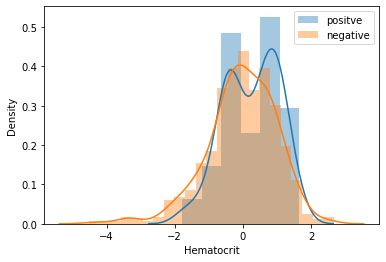

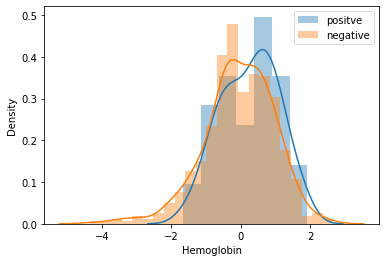

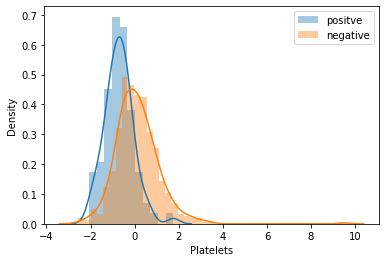

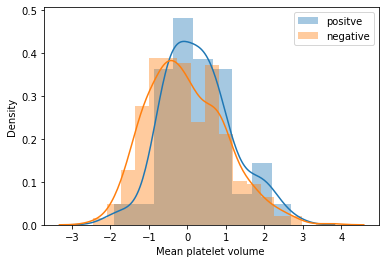

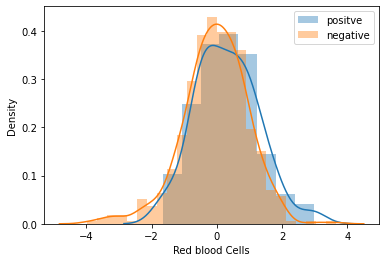

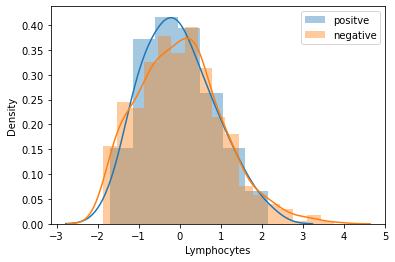

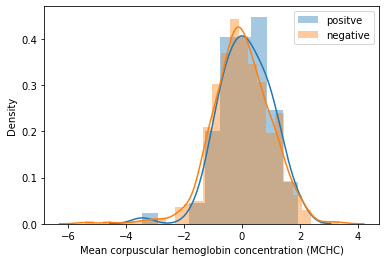

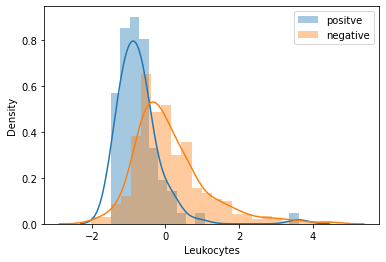

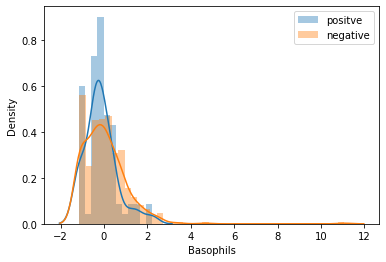

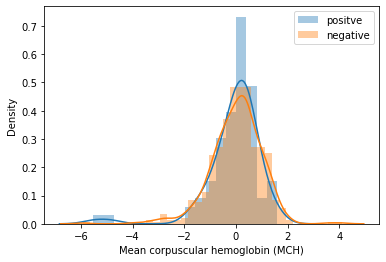

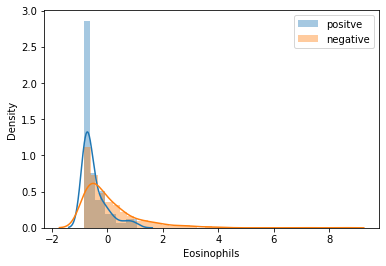

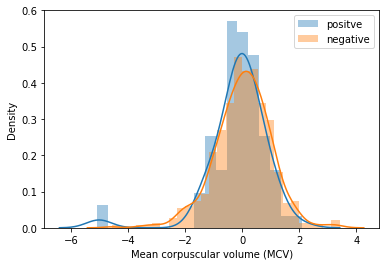

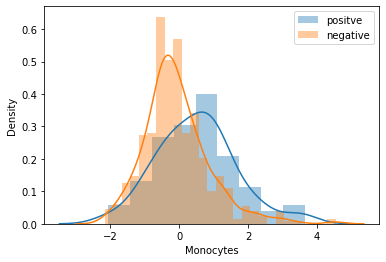

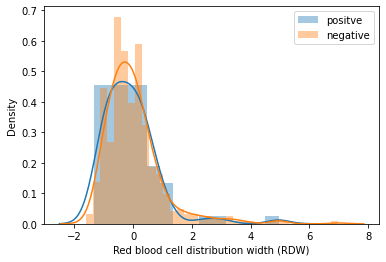

In [16]:
# Relation Target / Blood_columns
for col in blood_columns:
    plt.figure()
    sns.distplot(positive_df[col], label='positve')
    sns.distplot(negative_df[col], label='negative')
    plt.legend()

<AxesSubplot:xlabel='Patient age quantile', ylabel='count'>

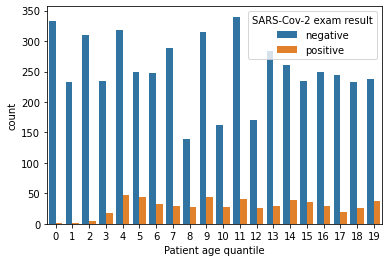

In [17]:
# Relation Target / age quantile
sns.countplot(x='Patient age quantile', hue='SARS-Cov-2 exam result', data=df)
# Graphique dans lequel on compte le nombre d'apparution de chaque patient age quantile pour les resultats positfs et negatif de la variable cible
# L'interpretation est un peu perturbante: car il semblerait que l'age soit lie a ce que l'on soit positif ou negatif au corona

In [18]:
# Relation Target / Viral
pd.crosstab(df['SARS-Cov-2 exam result'],df['Influenza A'])

Influenza A             detected  not_detected
SARS-Cov-2 exam result                        
negative                      18          1224
positive                       0           112

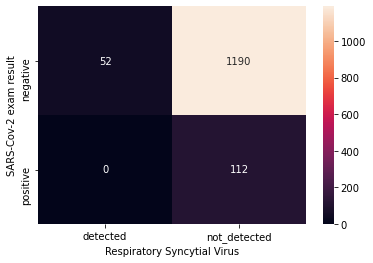

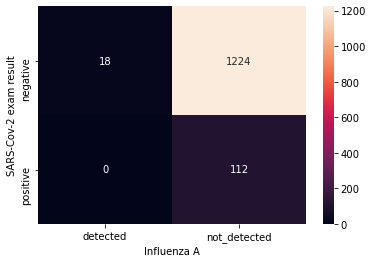

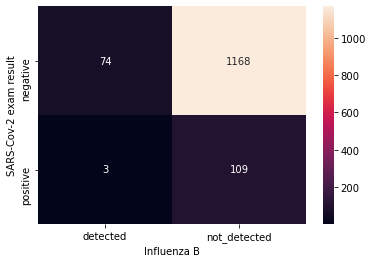

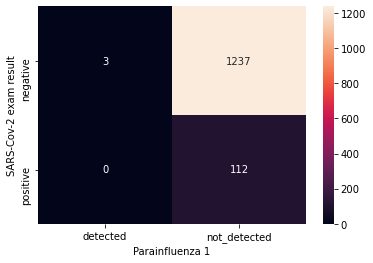

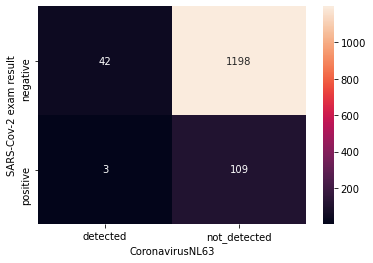

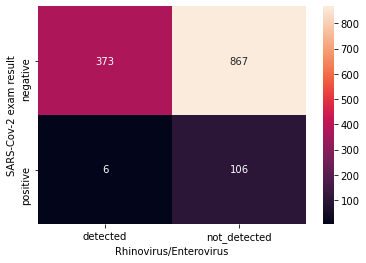

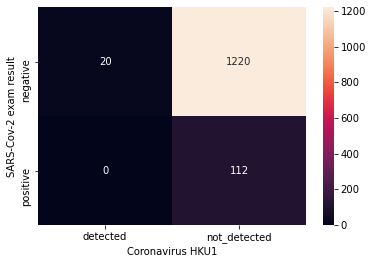

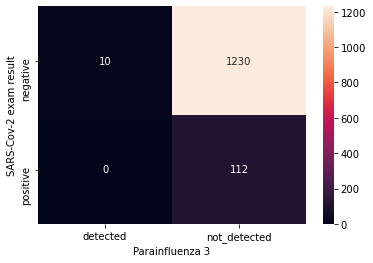

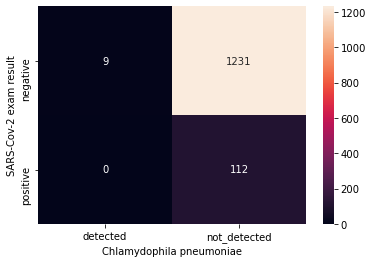

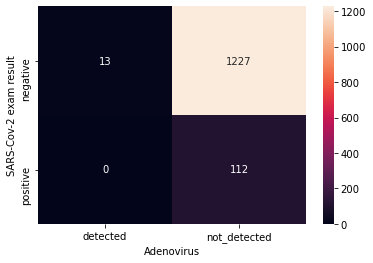

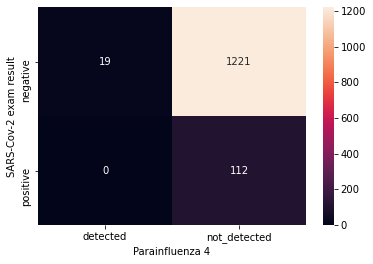

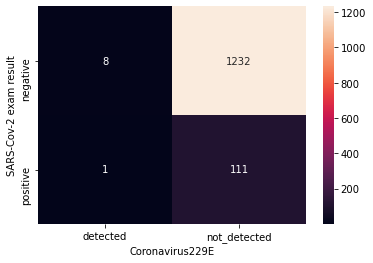

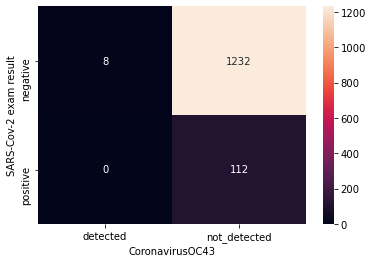

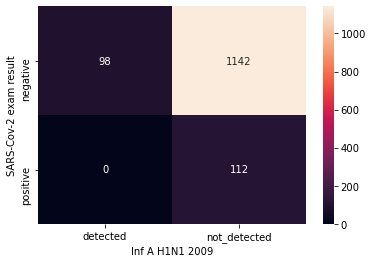

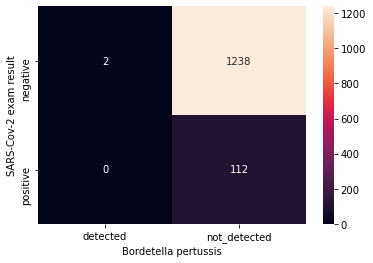

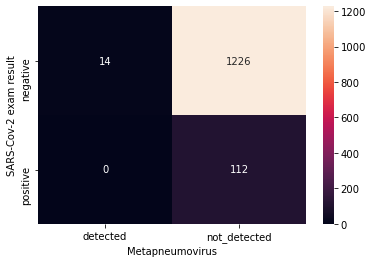

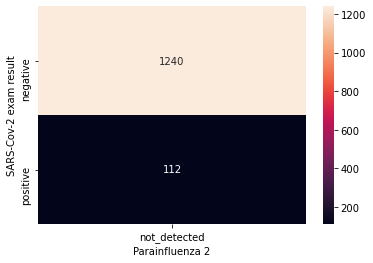

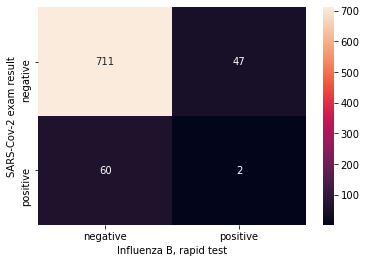

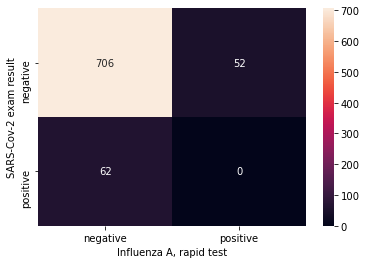

In [19]:
for col in viral_columns:
    plt.figure()
    sns.heatmap(pd.crosstab(df['SARS-Cov-2 exam result'], df[col]), annot=True, fmt='d')

In [ ]:
# Analyse un peu plus Avancee

# Relation Variables / Variables

# Relations Taux Sanguin

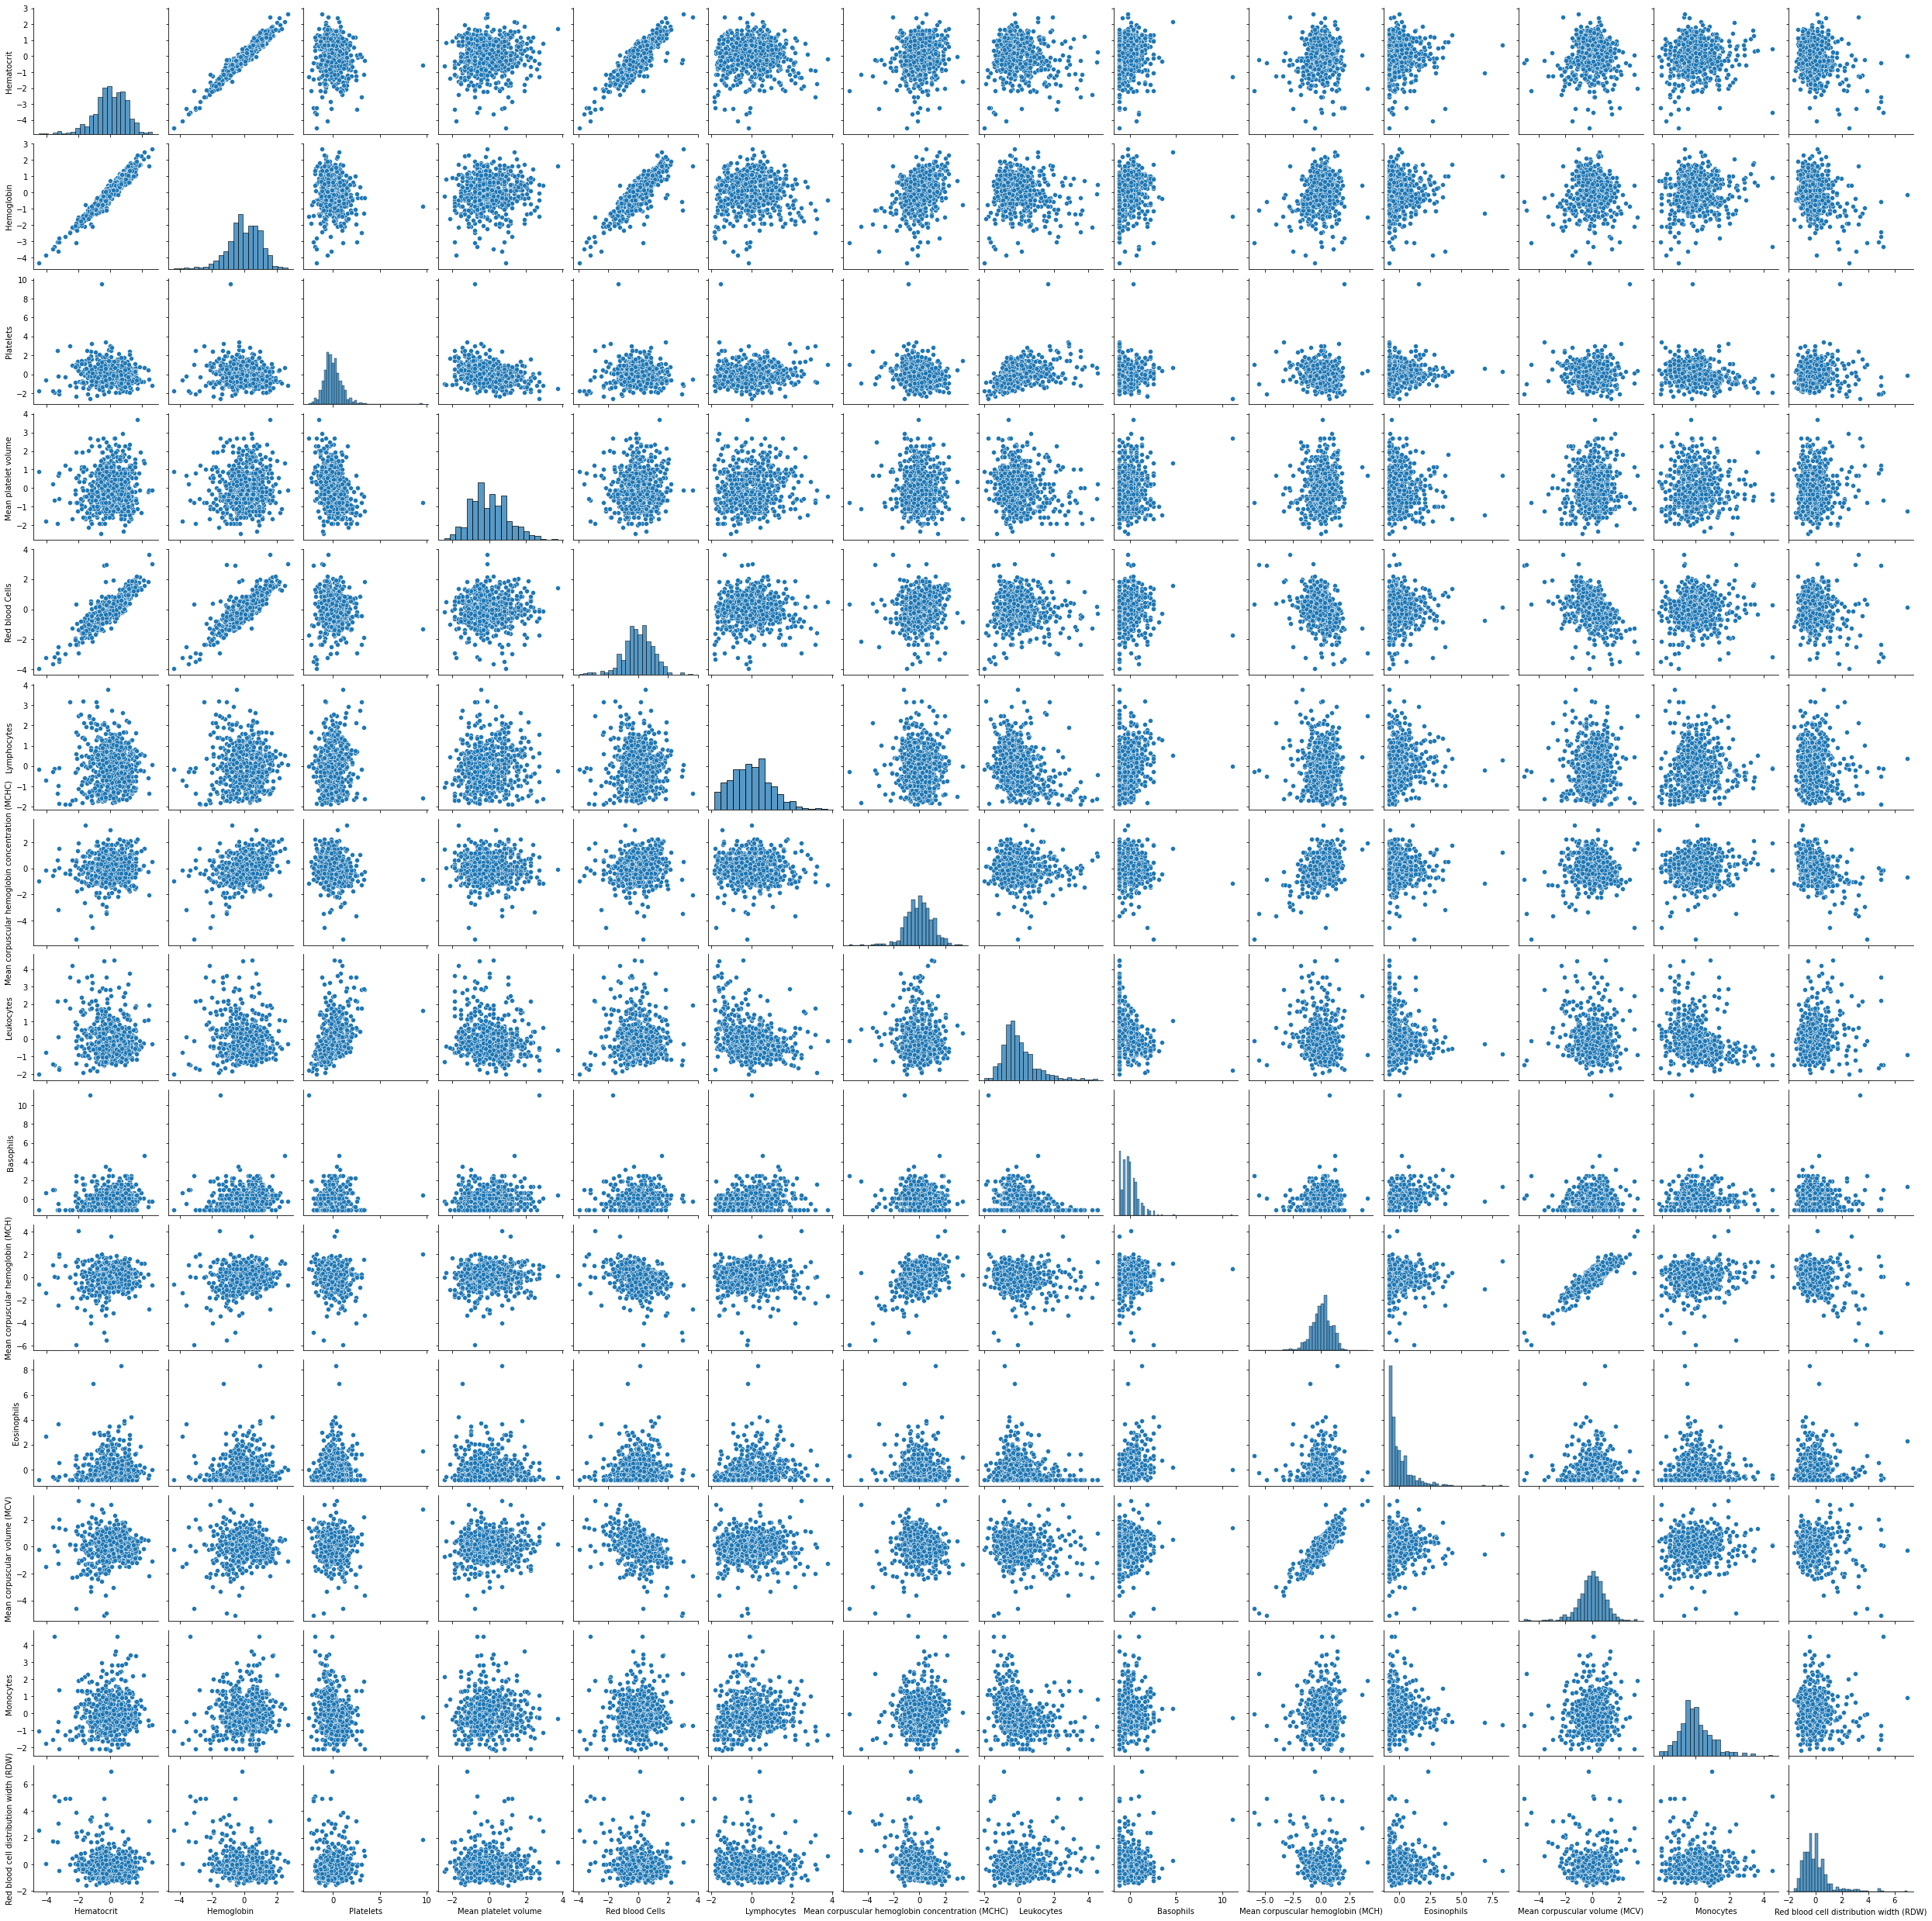

In [20]:
sns.pairplot(df[blood_columns])

<AxesSubplot:>

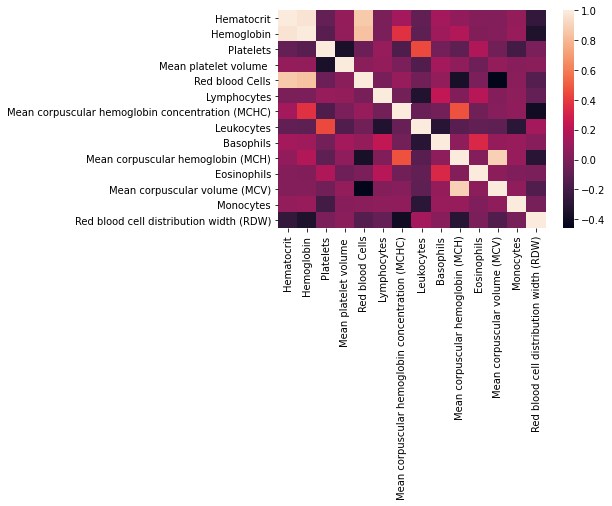

In [21]:
sns.heatmap(df[blood_columns].corr())
# plus une correlation est proche de 1 plus les deux variables evolue plus positivement les unes avec les autres

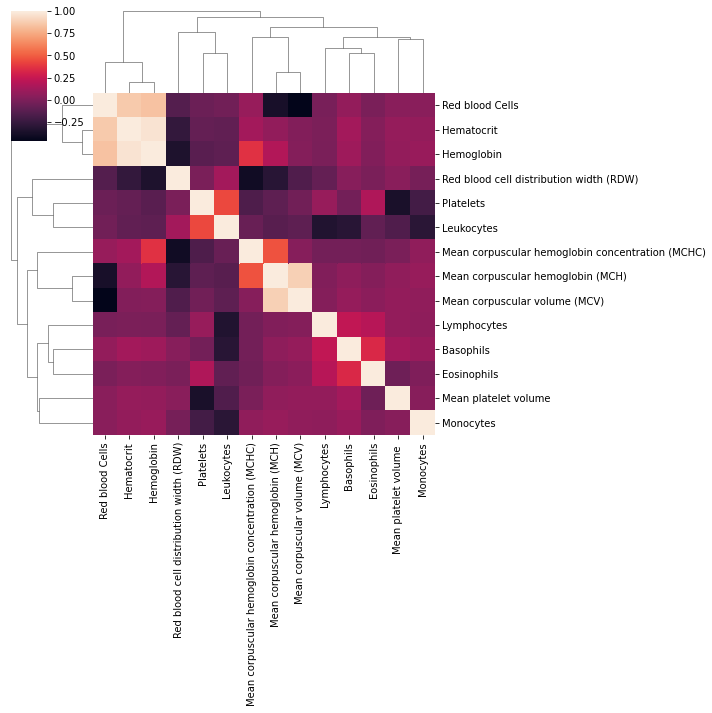

In [22]:
sns.clustermap(df[blood_columns].corr())
# Cette fonction rassembles directement les variables, les organises de maniere a cree cluster entre variable correle

<ipython-input-23-6d1c855d385f>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

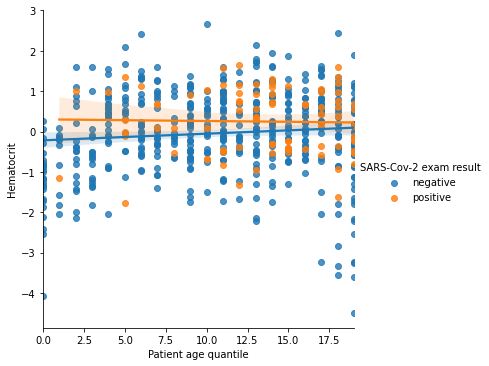

<Figure size 432x288 with 0 Axes>

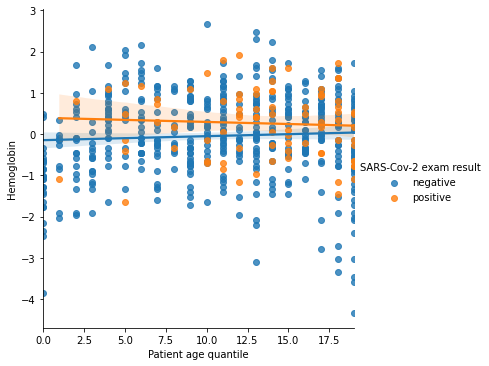

<Figure size 432x288 with 0 Axes>

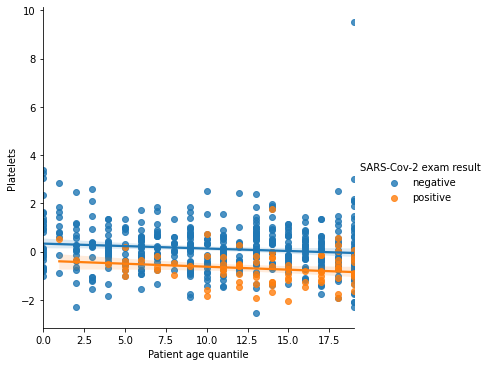

<Figure size 432x288 with 0 Axes>

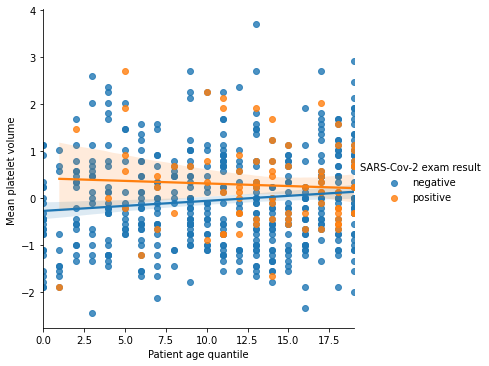

<Figure size 432x288 with 0 Axes>

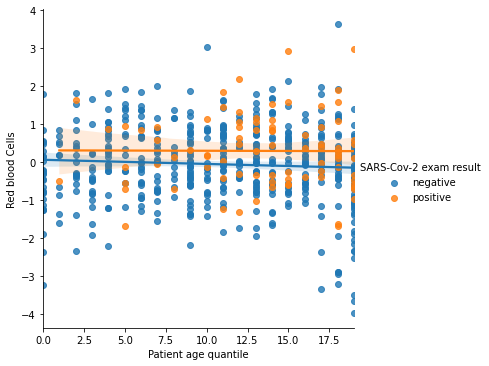

<Figure size 432x288 with 0 Axes>

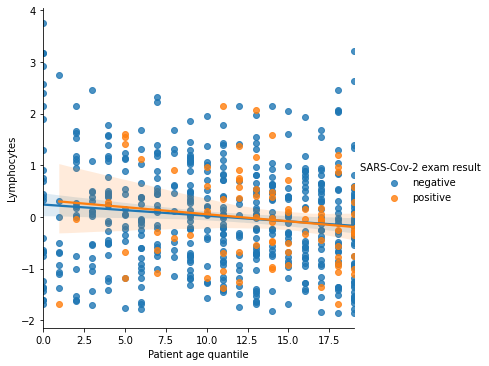

<Figure size 432x288 with 0 Axes>

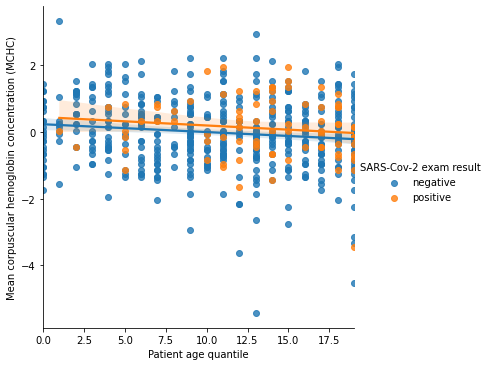

<Figure size 432x288 with 0 Axes>

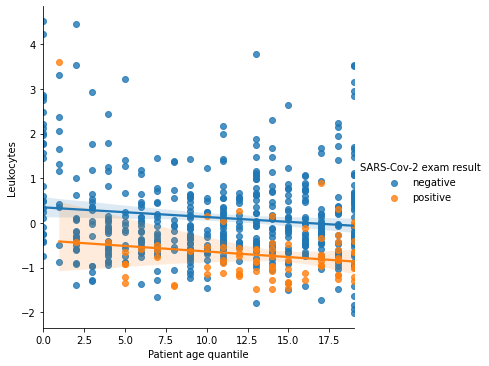

<Figure size 432x288 with 0 Axes>

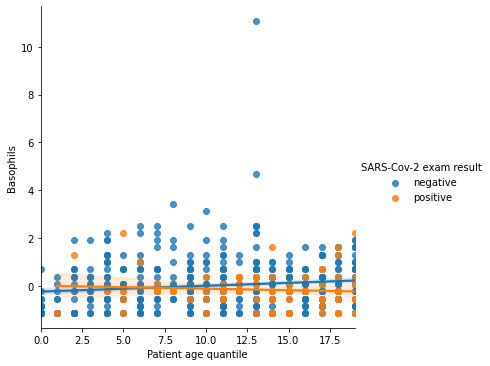

<Figure size 432x288 with 0 Axes>

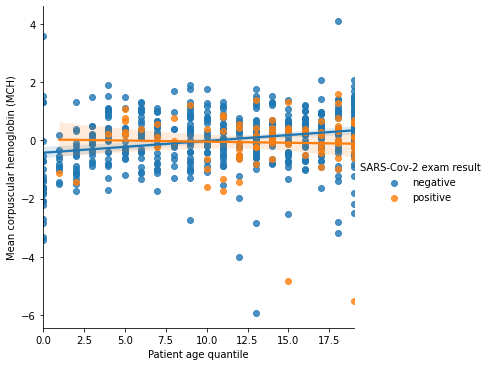

<Figure size 432x288 with 0 Axes>

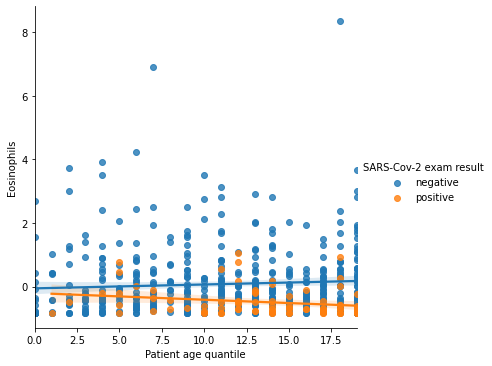

<Figure size 432x288 with 0 Axes>

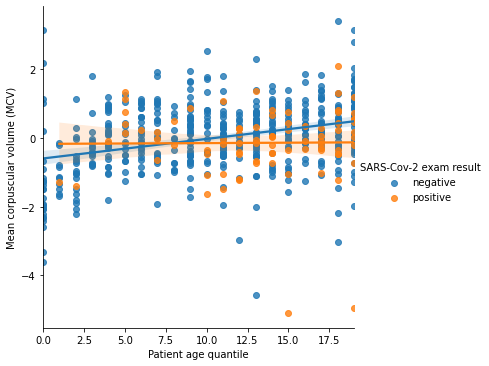

<Figure size 432x288 with 0 Axes>

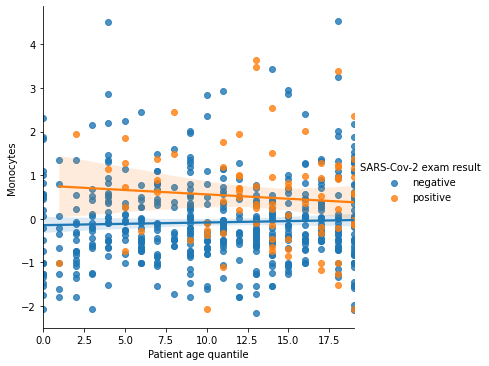

<Figure size 432x288 with 0 Axes>

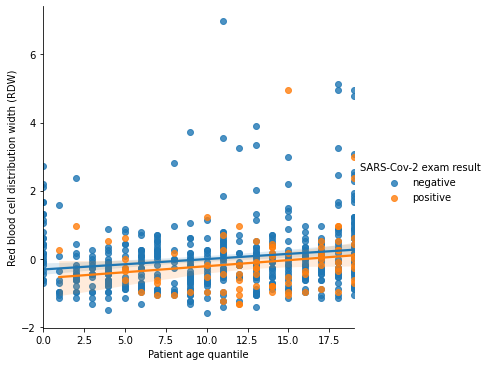

In [23]:
# Visualisation des raltions entre le sang et l'age (blood_data / age)
for col in blood_columns:
    plt.figure()
    sns.lmplot(x='Patient age quantile', y=col, hue='SARS-Cov-2 exam result', data=df)# elle permet de visualiser les courbes de regressions dans notre nuage de points

In [24]:
# Analyse entre les variables viral / viral
pd.crosstab(df['Influenza A'], df['Influenza A, rapid test'])

Influenza A, rapid test  negative  positive
Influenza A                                
detected                        2         4
not_detected                  245        15

In [25]:
pd.crosstab(df['Influenza B'], df['Influenza B, rapid test'])

Influenza B, rapid test  negative  positive
Influenza B                                
detected                       18        11
not_detected                  233         4

In [29]:
# relation maladie / blood data

df['est malade'] = np.sum(df[viral_columns[:-2]] == 'detected', axis=1) >=1
malade_df = df[df['est malade'] == True]
non_malade_df = df[df['est malade'] == False]

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

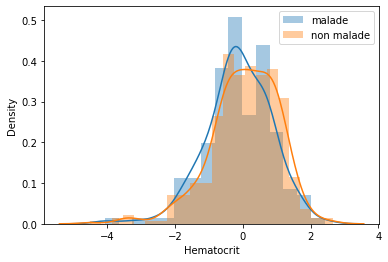

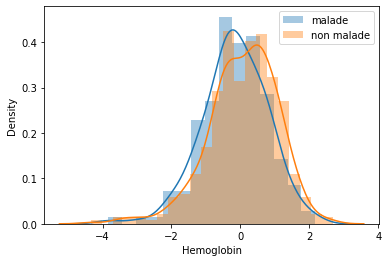

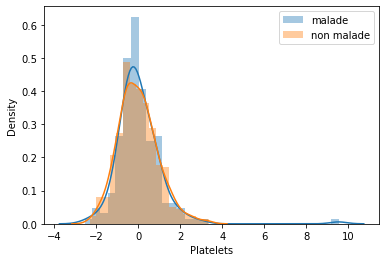

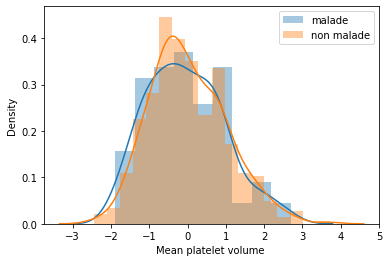

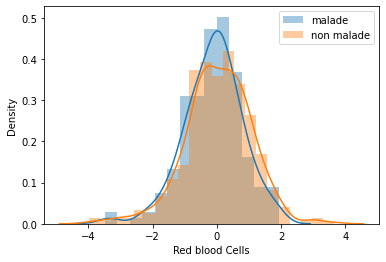

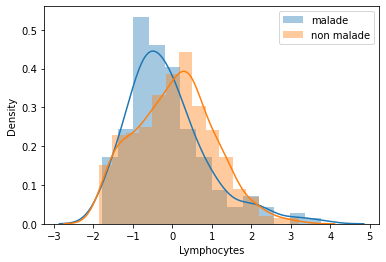

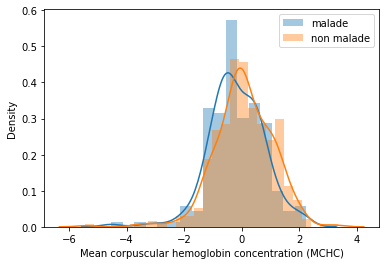

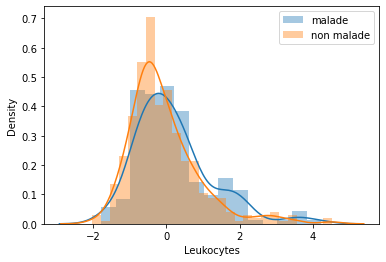

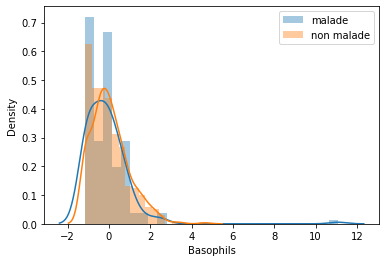

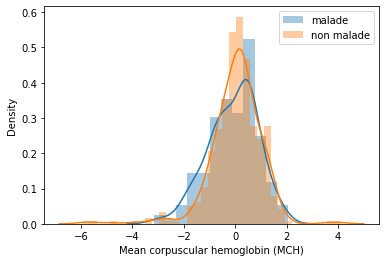

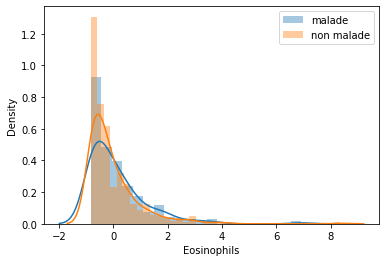

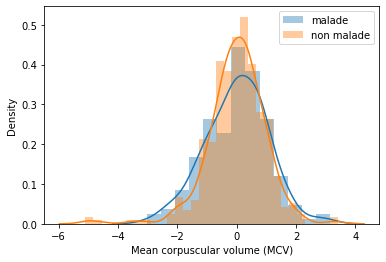

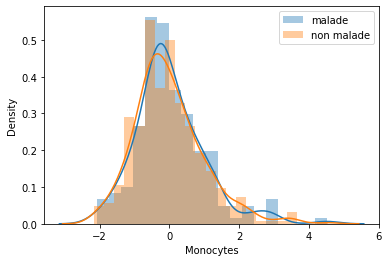

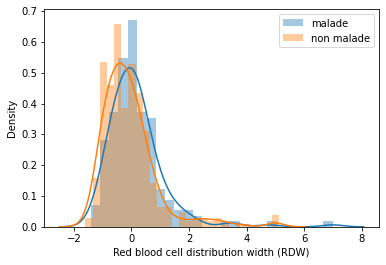

In [31]:
for col in blood_columns:
    plt.figure()
    sns.distplot(malade_df[col], label='malade')
    sns.distplot(non_malade_df[col], label='non malade')
    plt.legend()

In [32]:
# relation hospitalisation / est malade
def hospitalisation(df):
    if df['Patient addmited to regular ward (1=yes, 0=no)'] == 1:
        return 'surveillance'
    elif df['Patient addmited to semi-intensive unit (1=yes, 0=no)'] == 1:
        return 'soins semi-intensives'
    elif df['Patient addmited to intensive care unit (1=yes, 0=no)'] == 1:
        return 'soins intensifs'
    else:
        return 'inconnu'

In [35]:
df['statut'] = df.apply(hospitalisation, axis=1)
df.head()

Patient age quantile SARS-Cov-2 exam result  \
0                    13               negative   
1                    17               negative   
2                     8               negative   
3                     5               negative   
4                    15               negative   

   Patient addmited to regular ward (1=yes, 0=no)  \
0                                               0   
1                                               0   
2                                               0   
3                                               0   
4                                               0   

   Patient addmited to semi-intensive unit (1=yes, 0=no)  \
0                                                  0       
1                                                  0       
2                                                  0       
3                                                  0       
4                                                  0       

   Patient addmited to intensive care unit (1=yes, 0=no)  Hematocrit  \
0                                                  0             NaN   
1                                                  0        0.236515   
2                                                  0             NaN   
3                                                  0             NaN   
4                                                  0             NaN   

   Hemoglobin  Platelets  Mean platelet volume   Red blood Cells  Lymphocytes  \
0         NaN        NaN                    NaN              NaN          NaN   
1    -0.02234  -0.517413               0.010677         0.102004     0.318366   
2         NaN        NaN                    NaN              NaN          NaN   
3         NaN        NaN                    NaN              NaN          NaN   
4         NaN        NaN                    NaN              NaN          NaN   

   Mean corpuscular hemoglobin concentration (MCHC)  Leukocytes  Basophils  \
0                                               NaN         NaN        NaN   
1                                          -0.95079    -0.09461  -0.223767   
2                                               NaN         NaN        NaN   
3                                               NaN         NaN        NaN   
4                                               NaN         NaN        NaN   

   Mean corpuscular hemoglobin (MCH)  Eosinophils  \
0                                NaN          NaN   
1                          -0.292269     1.482158   
2                                NaN          NaN   
3                                NaN          NaN   
4                                NaN          NaN   

   Mean corpuscular volume (MCV)  Monocytes  \
0                            NaN        NaN   
1                       0.166192   0.357547   
2                            NaN        NaN   
3                            NaN        NaN   
4                            NaN        NaN   

   Red blood cell distribution width (RDW) Respiratory Syncytial Virus  \
0                                      NaN                         NaN   
1                                -0.625073                not_detected   
2                                      NaN                         NaN   
3                                      NaN                         NaN   
4                                      NaN                not_detected   

    Influenza A   Influenza B Parainfluenza 1 CoronavirusNL63  \
0           NaN           NaN             NaN             NaN   
1  not_detected  not_detected    not_detected    not_detected   
2           NaN           NaN             NaN             NaN   
3           NaN           NaN             NaN             NaN   
4  not_detected  not_detected    not_detected    not_detected   

  Rhinovirus/Enterovirus Coronavirus HKU1 Parainfluenza 3  \
0                    NaN              NaN             NaN   
1               detected     not_detected    not_detected   
2           

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

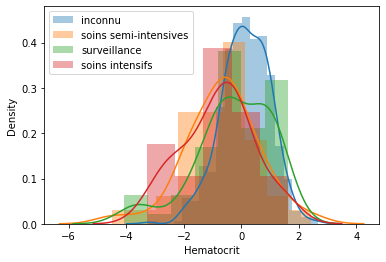

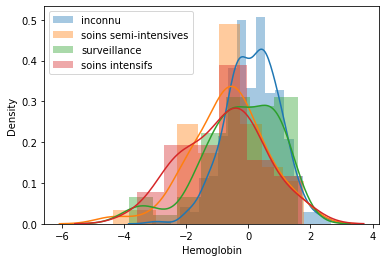

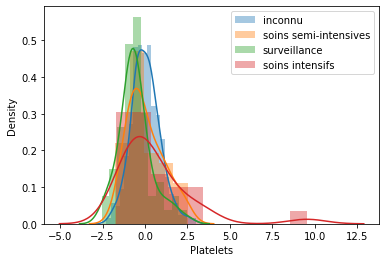

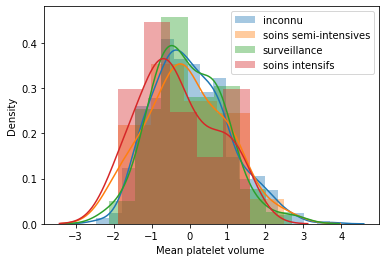

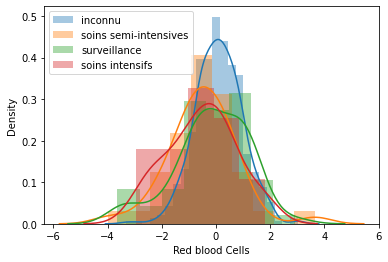

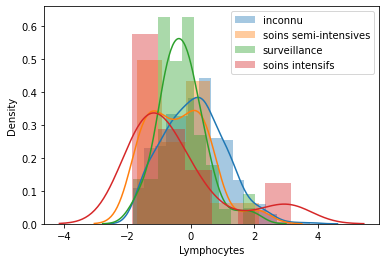

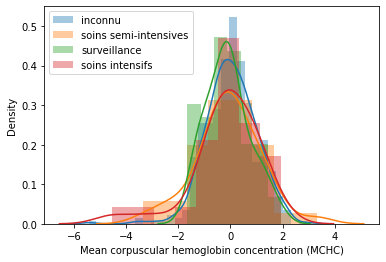

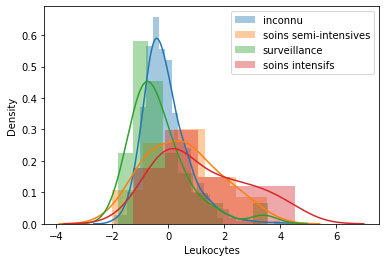

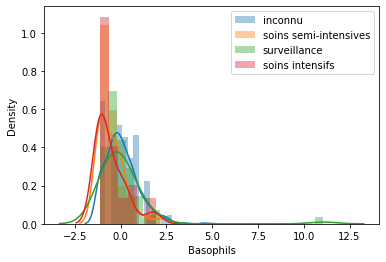

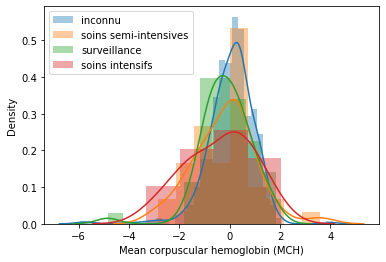

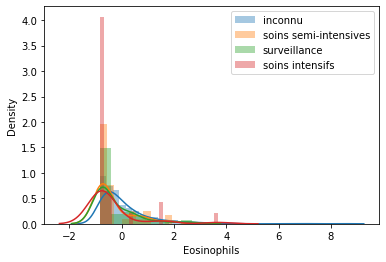

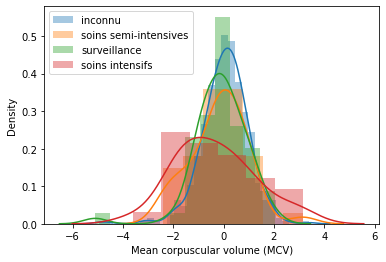

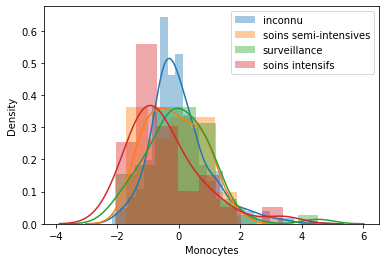

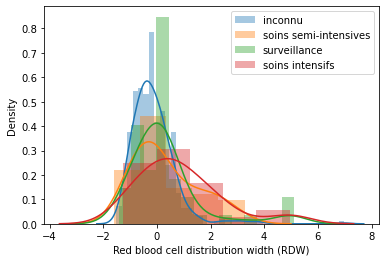

In [36]:
for col in blood_columns:
    plt.figure()
    for cat in df['statut'].unique():
        sns.distplot(df[df['statut']==cat][col], label=cat)
    plt.legend()

In [37]:
# Analyse des valeurs manquantes
df[blood_columns].count()

Hematocrit                                          603
Hemoglobin                                          603
Platelets                                           602
Mean platelet volume                                599
Red blood Cells                                     602
Lymphocytes                                         602
Mean corpuscular hemoglobin concentration (MCHC)    602
Leukocytes                                          602
Basophils                                           602
Mean corpuscular hemoglobin (MCH)                   602
Eosinophils                                         602
Mean corpuscular volume (MCV)                       602
Monocytes                                           601
Red blood cell distribution width (RDW)             602
dtype: int64

In [38]:
df[viral_columns].count()

Respiratory Syncytial Virus    1354
Influenza A                    1354
Influenza B                    1354
Parainfluenza 1                1352
CoronavirusNL63                1352
Rhinovirus/Enterovirus         1352
Coronavirus HKU1               1352
Parainfluenza 3                1352
Chlamydophila pneumoniae       1352
Adenovirus                     1352
Parainfluenza 4                1352
Coronavirus229E                1352
CoronavirusOC43                1352
Inf A H1N1 2009                1352
Bordetella pertussis           1352
Metapneumovirus                1352
Parainfluenza 2                1352
Influenza B, rapid test         820
Influenza A, rapid test         820
dtype: int64

In [39]:
df1 = df[viral_columns[:-2]]
df1['covid'] = df['SARS-Cov-2 exam result']
df1.dropna()['covid'].value_counts(normalize=True)

<ipython-input-39-2cac3867fbcc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['covid'] = df['SARS-Cov-2 exam result']


negative    0.91716
positive    0.08284
Name: covid, dtype: float64

In [40]:
df2 = df[blood_columns[:-2]]
df2['covid'] = df['SARS-Cov-2 exam result']
df2.dropna()['covid'].value_counts(normalize=True)

<ipython-input-40-11e105e274c4>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['covid'] = df['SARS-Cov-2 exam result']


negative    0.864775
positive    0.135225
Name: covid, dtype: float64

# Tests statistiques

In [41]:
from scipy.stats import ttest_ind
# C'est important de faire des test sur des classes a peut pres egal (donc equilibre)

In [42]:
positive_df.shape

(558, 38)

In [43]:
negative_df.shape

(5086, 38)

In [46]:
balanced_ned = negative_df.sample(positive_df.shape[0])

In [47]:
def t_test(col):
    alpha = 0.02
    stat, p = ttest_ind(balanced_ned[col].dropna(), positive_df[col].dropna())
    if p < alpha:
        return 'H0 Rejetee'
    else:
        return 0

In [48]:
for col in blood_columns:
    print(f'{col:-<50} {t_test(col)}')

Hematocrit---------------------------------------- 0
Hemoglobin---------------------------------------- 0
Platelets----------------------------------------- H0 Rejetee
Mean platelet volume ----------------------------- H0 Rejetee
Red blood Cells----------------------------------- 0
Lymphocytes--------------------------------------- 0
Mean corpuscular hemoglobin concentration (MCHC)-- 0
Leukocytes---------------------------------------- H0 Rejetee
Basophils----------------------------------------- 0
Mean corpuscular hemoglobin (MCH)----------------- 0
Eosinophils--------------------------------------- H0 Rejetee
Mean corpuscular volume (MCV)--------------------- H0 Rejetee
Monocytes----------------------------------------- 0
Red blood cell distribution width (RDW)----------- 0


# 3. Pretraitement des donnees (Pre-processing)

### 3.1 Objectif: transformer le jeu de donnees pour le mettre dans un format propice au MachineLearning
- **Creation du Train set / Test set**
- **Elimination des valeurs manquantes (NaN): dropna(), imputation, colonnes <vides>**
- **Encodage:** Toute variable categorielle doit etre transformer/encoder en variable numerique en utilisant OneHot Encoding, Ordinal Encoding ou alors coder une fonction d'encodage et ensuite utiliser la fonction replace et map de pandas pour appliquer sur le jeu de donnees.
- **Suppression des outliers nefastes au modele**
- **Feature Selection:** par exemple eliminer les variables dont la variance est nulle, les variables redondantes
- **Feature Engineering:** Creation de nouvelles variables a partir de celles existentes
- **Feature Scaling:**


# 4. Modelisation (Modelling)

### 4.1 Objectif: Developper et entrainer un modele de machine learning qui reponde a l'objectif final.
- **Definir une fonction d'evaluation**
- **Entrainement de differents modeles**
- **Optimisation avec GridSearchCV**
- **(Optionnel) Analyse des erreurs et retour au EDA**
- **Visualisation des courbes d'apprentissages (Learning Curve) et prise de decision**